In [1]:
import numpy as np
import random
import cv2 as cv
import pathlib, glob, os
import matplotlib.pyplot as plt
import time

import torch
torch.cuda.empty_cache()
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torch.autograd import Variable

import albumentations as album

In [2]:
import sys
import re

def read_pfm(fpath, expected_identifier="Pf"):
    # PFM format definition: http://netpbm.sourceforge.net/doc/pfm.html
    
    def _get_next_line(f):
        next_line = f.readline().decode('utf-8').rstrip()
        # ignore comments
        while next_line.startswith('#'):
            next_line = f.readline().rstrip()
        return next_line
    
    with open(fpath, 'rb') as f:
        #  header
        identifier = _get_next_line(f)
        if identifier != expected_identifier:
            raise Exception('Unknown identifier. Expected: "%s", got: "%s".' % (expected_identifier, identifier))

        try:
            line_dimensions = _get_next_line(f)
            dimensions = line_dimensions.split(' ')
            width = int(dimensions[0].strip())
            height = int(dimensions[1].strip())
        except:
            raise Exception('Could not parse dimensions: "%s". '
                            'Expected "width height", e.g. "512 512".' % line_dimensions)

        try:
            line_scale = _get_next_line(f)
            scale = float(line_scale)
            assert scale != 0
            if scale < 0:
                endianness = "<"
            else:
                endianness = ">"
        except:
            raise Exception('Could not parse max value / endianess information: "%s". '
                            'Should be a non-zero number.' % line_scale)

        try:
            data = np.fromfile(f, "%sf" % endianness)
            data = np.reshape(data, (height, width))
            data = np.flipud(data)
            with np.errstate(invalid="ignore"):
                data *= abs(scale)
        except:
            raise Exception('Invalid binary values. Could not create %dx%d array from input.' % (height, width))

        return data

In [3]:
""" 1rst time load training data
#Datasets
def ImageDataset(path):
    imgs_path = path + "/*"
    paths = []
    for classes in glob.glob(imgs_path):
        class_name = classes.split("\\")[-1]#/
        paths.append(class_name)
    print(len(paths), paths)

    # Transforms for low resolution images and high resolution images
    X = [0, 64, 128, 192, 256, 320, 384, 448,
         0, 64, 128, 192, 256, 320, 384, 448,
         0, 64, 128, 192, 256, 320, 384, 448,
         0, 64, 128, 192, 256, 320, 384, 448,
         0, 64, 128, 192, 256, 320, 384, 448,
         0, 64, 128, 192, 256, 320, 384, 448,
         0, 64, 128, 192, 256, 320, 384, 448,
         0, 64, 128, 192, 256, 320, 384, 448]
    Y = [0, 0, 0, 0, 0, 0, 0, 0,     
         64, 64, 64, 64, 64, 64, 64, 64,
         128, 128, 128, 128, 128, 128, 128, 128,
         192, 192, 192, 192, 192, 192, 192, 192,
         256, 256, 256, 256, 256, 256, 256, 256,
         320, 320, 320, 320, 320, 320, 320, 320, 
         384, 384, 384, 384, 384, 384, 384, 384,
         448, 448, 448, 448, 448, 448, 448, 448]

    for i in range (len(paths)):
        Img = np.zeros((81, 512, 512, 3))
        Imgs = np.zeros((81, 64, 64, 3))    
        
        GT_disparity = read_pfm(str('%s/%s/%s.pfm') %(path, paths[i], "gt_disp_lowres"))
        for nb in range (81):
            Img[nb] = cv.imread(str('%s/%s/%s%03d.png') %(path, paths[i], "input_Cam", nb))
            
        for idx in range (len(X)):            
            x_min=X[idx]
            y_min=Y[idx]
            
            aug = 0#np.random.randint(0,3)         
            for j in range (81): 
                if aug == 1:
                    Imgs[j] = cv.flip(np.squeeze(Img[j, x_min:x_min+64, y_min:y_min+64]), 0)
                elif aug == 2:
                    Imgs[j] = cv.flip(np.squeeze(Img[j, x_min:x_min+64, y_min:y_min+64]), 1)   
                else:
                    Imgs[j] = Img[j, x_min:x_min+64, y_min:y_min+64]
                    
                if j == 0:
                    cropped_Imgs = Imgs[j]
                else:
                    cropped_Imgs = np.concatenate((cropped_Imgs, Imgs[j]), axis=-1)

            cropped_GT_disparity = GT_disparity[x_min:x_min+64, y_min:y_min+64]
            if aug == 1:
                cropped_GT_disparity = cv.flip(cropped_GT_disparity, 0)
            elif aug == 2:
                cropped_GT_disparity = cv.flip(cropped_GT_disparity, 1)
            
            img_lr = (np.expand_dims(np.transpose(cropped_Imgs, (2, 0, 1)),0)/255.).astype('float32')
            gt_lr  = (np.expand_dims(np.expand_dims(cropped_GT_disparity,0),0)).astype('float32')
            
            if np.bitwise_and(i==0, idx ==0):
                Img_lr = img_lr
                Gt_lr  = gt_lr
            else:
                Img_lr =  np.concatenate((Img_lr, img_lr), axis=0)
                Gt_lr  =  np.concatenate((Gt_lr, gt_lr), axis=0)
        
    return Img_lr, Gt_lr

batch_size = 32

x_train, y_train = ImageDataset("hci_dataset/additional")
np.save('x_train_64_0.npy', x_train)
np.save('y_train_64_0.npy', y_train)

data_train = torch.utils.data.TensorDataset(torch.from_numpy(x_train), torch.from_numpy(y_train))
trainloader = DataLoader(data_train, batch_size = batch_size, shuffle=True, drop_last=True)
print(len(trainloader))
"""
"""
    X = [0, 32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448,
         0, 32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448,
         0, 32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448,
         0, 32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448,
         0, 32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448,
         0, 32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448,
         0, 32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448,
         0, 32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448,
         0, 32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448,
         0, 32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448,
         0, 32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448,
         0, 32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448,
         0, 32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448,
         0, 32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448,
         0, 32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448,]
    Y = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,  
         32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
         64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64,
         96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96,
         128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128, 128,
         160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160,
         192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192, 192,
         224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224, 224,
         256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256, 256,
         288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288, 288,
         320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320, 320,
         352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352,
         384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384, 384,
         416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416, 416,
         448, 448, 448, 448, 448, 448, 448, 448, 448, 448, 448, 448, 448, 448, 448,]
"""

'\n    X = [0, 32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448,\n         0, 32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448,\n         0, 32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448,\n         0, 32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448,\n         0, 32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448,\n         0, 32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448,\n         0, 32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448,\n         0, 32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448,\n         0, 32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448,\n         0, 32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448,\n         0, 32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448,\n         0, 32, 64, 96, 128, 160, 192, 224, 256, 288, 320, 352, 384, 416, 448,\n         0, 32, 64, 96, 128, 160, 192

In [4]:
#Datasets
batch_size = 16*2
data_train = torch.utils.data.TensorDataset(torch.from_numpy(np.load('x_train_64_0.npy')), torch.from_numpy(np.load('y_train_64_0.npy')))
trainloader = DataLoader(data_train, batch_size = batch_size, shuffle=True, drop_last=True)
print(len(trainloader))

32


In [5]:
#Datasets
def ImageDataset_T(path):
    imgs_path = path + "/*"
    paths = []
    for classes in glob.glob(imgs_path):
        class_name = classes.split("\\")[-1]#/
        paths.append(class_name)
    print(len(paths), paths)

    # Transforms for low resolution images and high resolution images
    X = [0, 64, 128, 192, 256, 320, 384, 448,
         0, 64, 128, 192, 256, 320, 384, 448,
         0, 64, 128, 192, 256, 320, 384, 448,
         0, 64, 128, 192, 256, 320, 384, 448,
         0, 64, 128, 192, 256, 320, 384, 448,
         0, 64, 128, 192, 256, 320, 384, 448,
         0, 64, 128, 192, 256, 320, 384, 448,
         0, 64, 128, 192, 256, 320, 384, 448]
    Y = [0, 0, 0, 0, 0, 0, 0, 0,     
         64, 64, 64, 64, 64, 64, 64, 64,
         128, 128, 128, 128, 128, 128, 128, 128,
         192, 192, 192, 192, 192, 192, 192, 192,
         256, 256, 256, 256, 256, 256, 256, 256,
         320, 320, 320, 320, 320, 320, 320, 320, 
         384, 384, 384, 384, 384, 384, 384, 384,
         448, 448, 448, 448, 448, 448, 448, 448]

    for i in range (len(paths)):
        Img = np.zeros((81, 512, 512, 3))
        Imgs = np.zeros((81, 64, 64, 3))    
        
        GT_disparity = read_pfm(str('%s/%s/%s.pfm') %(path, paths[i], "gt_disp_lowres"))
        for nb in range (81):
            Img[nb] = cv.imread(str('%s/%s/%s%03d.png') %(path, paths[i], "input_Cam", nb))
            
        for idx in range (len(X)):            
            x_min=X[idx]
            y_min=Y[idx]       
            for j in range (81): 
                Imgs[j] = Img[j, x_min:x_min+64, y_min:y_min+64]
                if j == 0:
                    cropped_Imgs = Imgs[j]
                else:
                    cropped_Imgs = np.concatenate((cropped_Imgs, Imgs[j]), axis=-1)

            cropped_GT_disparity = GT_disparity[x_min:x_min+64, y_min:y_min+64]
            
            img_lr = (np.expand_dims(np.transpose(cropped_Imgs, (2, 0, 1)),0)/255.).astype('float32')
            gt_lr  = (np.expand_dims(np.expand_dims(cropped_GT_disparity,0),0)).astype('float32')
            
            if np.bitwise_and(i==0, idx ==0):
                Img_lr = img_lr
                Gt_lr  = gt_lr
            else:
                Img_lr =  np.concatenate((Img_lr, img_lr), axis=0)
                Gt_lr  =  np.concatenate((Gt_lr, gt_lr), axis=0)
        
    return Img_lr, Gt_lr

batch_size = 4*4

x_test, y_test = ImageDataset_T("hci_dataset/training")
data_test = torch.utils.data.TensorDataset(torch.from_numpy(x_test), torch.from_numpy(y_test))
testloader = DataLoader(data_test, batch_size = batch_size, shuffle=False, drop_last=True)
print(len(testloader))

4 ['boxes', 'cotton', 'dino', 'sideboard']
16


In [6]:
class _ASPP(nn.Module):
    """
    Atrous spatial pyramid pooling with image-level feature
    """
    def __init__(self, in_ch, out_ch, rates):
        super().__init__()
        self.stages = nn.Module()
        for i, rate in enumerate(rates):
            self.stages.add_module(
                "C{}".format(i + 1), nn.Conv2d(in_ch, out_ch, 3, 1, padding=rate, dilation=rate, bias=False))

    def forward(self, x):
        return torch.cat([stage(x) for stage in self.stages.children()], dim=1)
        
#https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728
#Xception
class _depthwise_separable_conv(nn.Module):#nn.Module
    def __init__(self, in_ch, out_ch): #, kernels_per_layer
        super().__init__() 
        self.depthwise = nn.Conv2d(in_ch, in_ch, kernel_size=3, padding='same', groups=in_ch) #in_ch * kernels_per_layer
        self.pointwise = nn.Conv2d(in_ch, out_ch, kernel_size=1, padding='same') #in_ch * kernels_per_layer

    def forward(self, x): 
        out = self.depthwise(x) 
        out = self.pointwise(out) 
        return out
    
class _DWSConvBnReLU(nn.Sequential):
    """
    Cascade of depthwise separable 2D convolution, batch norm, and ReLU.
    """
    def __init__(self, in_ch, out_ch, kernel_size=3, relu=True):
        super().__init__()
        self.add_module("DWS_Conv", _depthwise_separable_conv(in_ch, out_ch))
        self.add_module("BN", nn.BatchNorm2d(out_ch))

        if relu:
            self.add_module("RELU", nn.ReLU())#inplace=True
            
class _Bloc_1(nn.Sequential):
    def __init__(self, kernel_size=3):
        super().__init__()
        self.add_module("DWS_Conv_1", _DWSConvBnReLU(256, 128))
        self.add_module("DWS_Conv_2", _DWSConvBnReLU(128, 128))
        self.add_module("DWS_Conv_3", _DWSConvBnReLU(128, 128, relu=False))
        
class _All_Bloc_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.B_1 = _DWSConvBnReLU(256, 128, relu=False)
        self.B_2 = _Bloc_1()

    def forward(self, x):
        x_ini = x
        x1 = self.B_1(x_ini)
        x2 = self.B_2(x_ini)
        x_f = x1 + x2

        return x_f    
    
class _Bloc(nn.Sequential):
    def __init__(self, kernel_size=3):
        super().__init__()
        self.add_module("DWS_Conv_1", _DWSConvBnReLU(128, 128))
        self.add_module("DWS_Conv_2", _DWSConvBnReLU(128, 128))
        self.add_module("DWS_Conv_3", _DWSConvBnReLU(128, 128, relu=False))
        
class _All_Bloc(nn.Module):
    def __init__(self):
        super().__init__()
        self.B_1 = _DWSConvBnReLU(128, 128, relu=False)
        self.B_2 = _Bloc()

    def forward(self, x):
        x_ini = x
        x1 = self.B_1(x_ini)
        x2 = self.B_2(x_ini)
        x_f = x1 + x2

        return x_f     

In [7]:
class SAI_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.in_ch = 81*3
        self.rates = [1, 2, 4, 8, 16, 32]#[6, 12, 18] #

        self.ASPP_1 = _ASPP(self.in_ch, self.in_ch, self.rates)
        self.ASPP_2 = _DWSConvBnReLU(self.in_ch * len(self.rates), 256)#len(self.rates)
        
        self.bloc1 = _All_Bloc_1()
        self.bloc  = _All_Bloc()
        self.final_1 = _DWSConvBnReLU(128,128)
        self.final_2 = nn.Conv2d(128,1, kernel_size=1, padding='same')

    def forward(self, x):
        x = self.ASPP_1(x)
        x = self.ASPP_2(x)
        x = self.bloc1(x)
        for i in range(3):#7
            x = self.bloc(x)
        x = self.final_1(x)
        x = self.final_2(x)

        return x

#Instantiate the model
model = SAI_Model()

In [8]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print(device)
model.to(device)
summary(model,(81*3,64,64))

Tensor = torch.cuda.FloatTensor if device == 'cuda:0' else torch.FloatTensor

# Load pretrained models 
load_pretrained_models = True
model_path = "SAI_model_64_3L_best.pth"
if load_pretrained_models:
    model.load_state_dict(torch.load(model_path,map_location=device))

cuda:0
Layer (type:depth-idx)                                  Output Shape              Param #
├─_ASPP: 1-1                                            [-1, 1458, 64, 64]        --
|    └─Module: 2                                        []                        --
|    |    └─Conv2d: 3-1                                 [-1, 243, 64, 64]         531,441
|    |    └─Conv2d: 3-2                                 [-1, 243, 64, 64]         531,441
|    |    └─Conv2d: 3-3                                 [-1, 243, 64, 64]         531,441
|    |    └─Conv2d: 3-4                                 [-1, 243, 64, 64]         531,441
|    |    └─Conv2d: 3-5                                 [-1, 243, 64, 64]         531,441
|    |    └─Conv2d: 3-6                                 [-1, 243, 64, 64]         531,441
├─_DWSConvBnReLU: 1-2                                   [-1, 256, 64, 64]         --
|    └─_depthwise_separable_conv: 2-1                   [-1, 256, 64, 64]         --
|    |    └─Conv2d: 3-7

In [9]:
class Sobel(nn.Module):
    def __init__(self):
        super(Sobel, self).__init__()
        self.edge_conv = nn.Conv2d(1, 2, kernel_size=3, stride=1, padding=1, bias=False)
        edge_kx = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
        edge_ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
        edge_k = np.stack((edge_kx, edge_ky))

        edge_k = torch.from_numpy(edge_k).float().view(2, 1, 3, 3)
        self.edge_conv.weight = nn.Parameter(edge_k)
        
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        out = self.edge_conv(x) 
        out = out.contiguous().view(-1, 2, x.size(2), x.size(3))
  
        return out

get_gradient = Sobel().cuda()
cos = nn.CosineSimilarity(dim=1, eps=0)

In [10]:
#Optimizer
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)#weight_decay=0.001

val_min = 1

start_time = time.time()

train_losses=[]
for epoch in range(1,1):  # loop over the dataset multiple times
    model.train()
    train_loss = 0.0
    for i, data in enumerate(trainloader):#(trainloader,0)
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs.cuda()
        labels.cuda()

        inputs = torch.autograd.Variable(inputs.type(Tensor))
        labels = torch.autograd.Variable(labels.type(Tensor))
        
        ones = torch.ones(labels.size(0), 1, labels.size(2), labels.size(3)).float().cuda()
        ones = torch.autograd.Variable(ones)
        
        optimizer.zero_grad()

        output = model(inputs)
        
        depth_grad = get_gradient(labels)
        output_grad = get_gradient(output)
        depth_grad_dx = depth_grad[:, 0, :, :].contiguous().view_as(labels)
        depth_grad_dy = depth_grad[:, 1, :, :].contiguous().view_as(labels)
        output_grad_dx = output_grad[:, 0, :, :].contiguous().view_as(labels)
        output_grad_dy = output_grad[:, 1, :, :].contiguous().view_as(labels)

        depth_normal = torch.cat((-depth_grad_dx, -depth_grad_dy, ones), 1)
        output_normal = torch.cat((-output_grad_dx, -output_grad_dy, ones), 1)

        loss_1 = torch.abs(output - labels).mean() #criterion(output, labels)
        loss_dx = torch.abs(output_grad_dx - depth_grad_dx).mean()
        loss_dy = torch.abs(output_grad_dy - depth_grad_dy).mean()
        loss_normal = torch.abs(1 - cos(output_normal, depth_normal)).mean()

        loss = 1/3*loss_1 + 1/3*(loss_dx + loss_dy) + 1/3*loss_normal
        
        #loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss = train_loss/len(trainloader)
    # append training loss
    train_losses.append(train_loss)
    
    #validation 
    model.eval()
    val_losses=0
    with torch.no_grad():
        #Batch of test images
        for j, imgs in enumerate(testloader):
            images, GT = imgs#["lr"], imgs["GT"]
            #Sample outputs
            output = model(images.type(Tensor))

            val_loss = torch.abs(output - GT.type(Tensor)).mean() 
            val_losses += val_loss.item()#*inputs.size(0)

        val_losses = val_losses/len(testloader)
        
    print('Epoch: {} \tTraining Loss: {:.5f}, \tValidation Loss: {:.5f}'.format(epoch, train_loss, val_losses))
    if val_losses < val_min:
        torch.save(model.state_dict(), "SAI_model_64_3L_best.pth")
        val_min = val_losses
    
    # Save model checkpoints
    if (epoch)%5 == 0:
        torch.save(model.state_dict(), "SAI_model_64_3L.pth")
        #save model
        torch.save(model.state_dict(), f"SAI_model_64_3L_{epoch}.pth")
        print(f"save model: {epoch}")
        
print('Finished Training')
print("--- %s seconds ---" % (time.time() - start_time))

Finished Training
--- 0.0005772113800048828 seconds ---


train_loss: 0.058396533131599426
GT Images


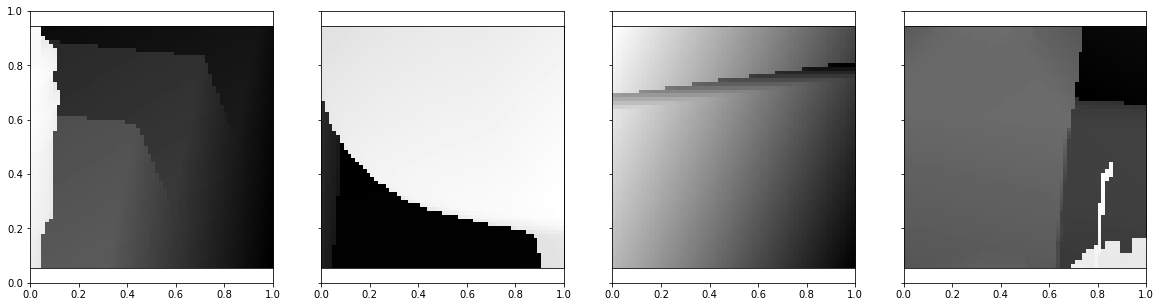

Output Images


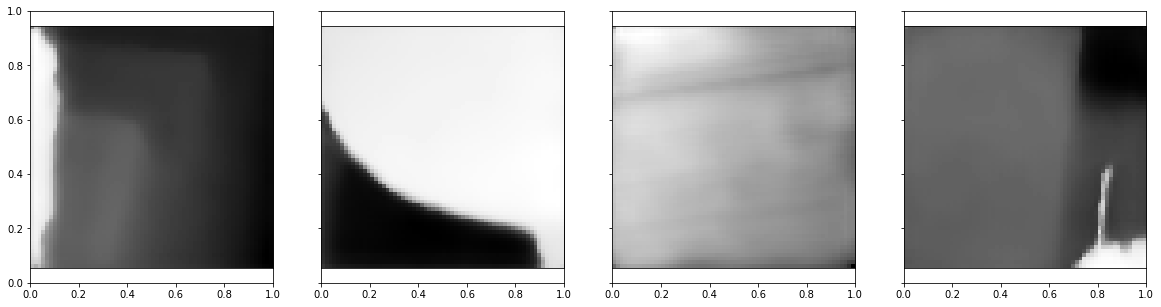

In [11]:
#Batch of train images
dataiter = iter(trainloader)
imgs = dataiter.next()
images, GT = imgs #["lr"], imgs["GT"]

model.eval()
with torch.no_grad():
    #Sample outputs
    output = model(images.type(Tensor))
    
    print(f"train_loss: {torch.abs(output - GT.type(Tensor)).mean()}")

    output = output.cpu()
    output = output.view(16*2, 1, 64, 64)
    output = output.detach().numpy()

    def imshow(img):
        plt.imshow(np.squeeze(np.transpose(img, (1, 2, 0))), cmap = "gray") 

    #GT Images
    print("GT Images")
    fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(20,5))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        imshow(GT[idx])
    plt.show()

    #OutputImages
    print("Output Images")
    fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(20,5))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        imshow(output[idx])
    plt.show()

In [12]:
def Test(data, X, Y): 
    model.eval()
    with torch.no_grad():
        Disparity_lr = np.zeros((512, 512))
        GT_disp      = np.zeros((512, 512))
        
        for i in range(0,9):
            for j in range(0,9):
                if np.logical_and(i==0, j==0):
                    Imgs = cv.imread(str('%s/%s%03d.png') %(data, "input_Cam", 0))
                    #cropped_Imgs = Imgs[x_min:x_min+64, y_min:y_min+64]
                else:
                    img = cv.imread(str('%s/%s%03d.png') %(data, "input_Cam", i*9 + j))
                    #cropped_img = img[x_min:x_min+64, y_min:y_min+64]
                    Imgs = np.concatenate((Imgs, img), axis=-1)

        for ii in range(8):
            img_lr = torch.from_numpy(np.zeros((8, 81*3, 64, 64)).astype('float32'))
            gt_lr  = np.zeros((8, 64, 64)).astype('float32')
            for jj in range (8):
                x_min=X[ii + jj*8] 
                y_min=Y[ii + jj*8]

                cropped_Imgs = Imgs[x_min:x_min+64, y_min:y_min+64]

                GT_disparity = read_pfm(str('%s/%s.pfm') %(data, "gt_disp_lowres"))
                cropped_GT_disparity = GT_disparity[x_min:x_min+64, y_min:y_min+64]

                cropped_Imgs_tensor = (torch.from_numpy(cropped_Imgs)).permute(2, 0, 1)
                #cropped_GT_disparity_tensor = torch.from_numpy(np.expand_dims(cropped_GT_disparity,0).copy())

                cropped_Imgs_tensor = (cropped_Imgs_tensor / 255.0)
                #cropped_GT_disparity_tensor = (cropped_GT_disparity_tensor)

                img_lr[jj] = cropped_Imgs_tensor
                gt_lr[jj]  = cropped_GT_disparity#_tensor

            #Sample outputs
            output = model(img_lr.type(Tensor))

            output = output.cpu()
            output = output.view(8, 1, 64, 64)
            output = output.detach().numpy()
            for k in range(8):
                Disparity_lr[ii*64:(ii+1)*64, k*64:(k+1)*64] = np.squeeze(output[k,...])
                GT_disp     [ii*64:(ii+1)*64, k*64:(k+1)*64] = gt_lr[k,...] #np.squeeze(gt_lr[k,...])

        fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20,10))
        ax_1 = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
        plt.imshow(GT_disp, cmap ='gray')
        ax_2 = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
        plt.imshow(Disparity_lr, cmap ='gray')
        plt.show()

        fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20,10))
        ax_1 = fig.add_subplot(1, 2, 1, xticks=[], yticks=[])
        plt.imshow(GT_disp-Disparity_lr, cmap ='gray')
        ax_2 = fig.add_subplot(1, 2, 2, xticks=[], yticks=[])
        plt.imshow(np.abs(GT_disp-Disparity_lr)<0.07, cmap ='gray')
        plt.show()

        print(np.mean(np.abs(GT_disp-Disparity_lr)<0.07)*100)
        print(np.mean(np.abs(GT_disp-Disparity_lr)))

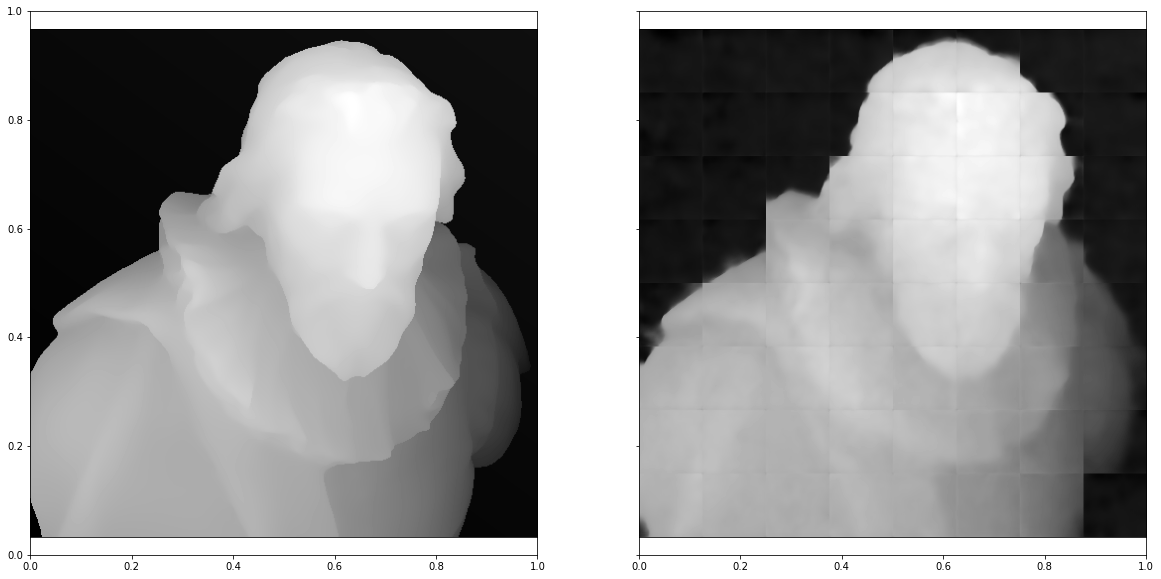

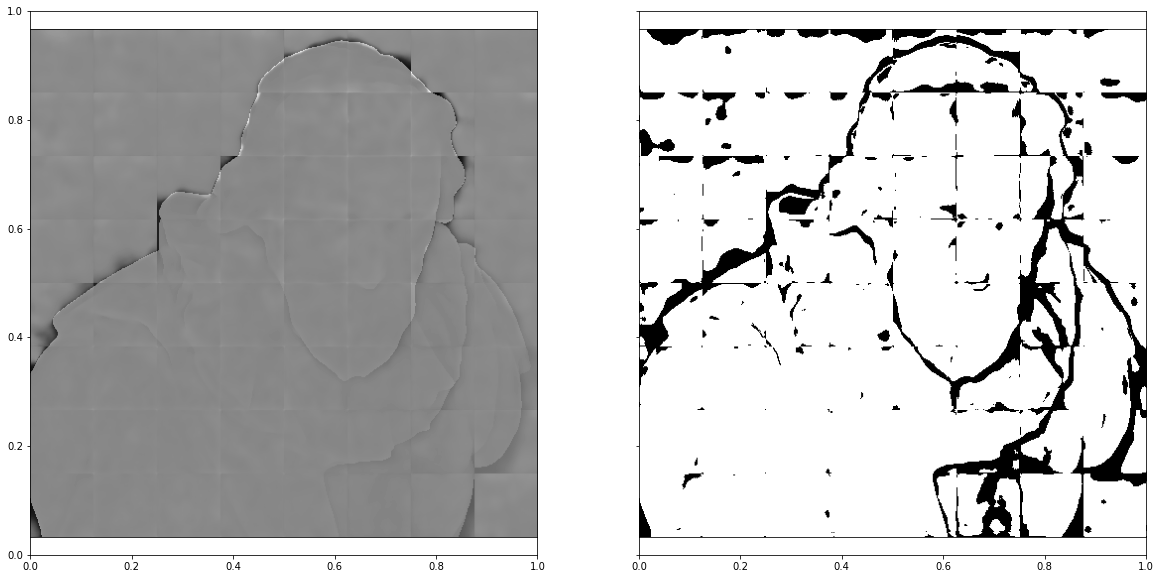

87.74909973144531
0.0481274378231207


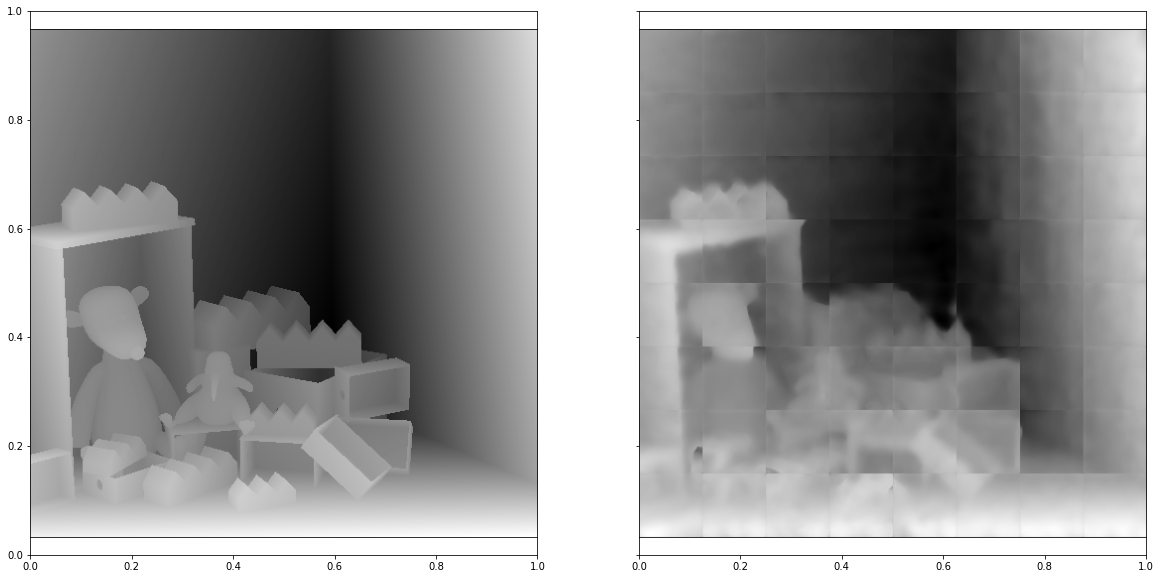

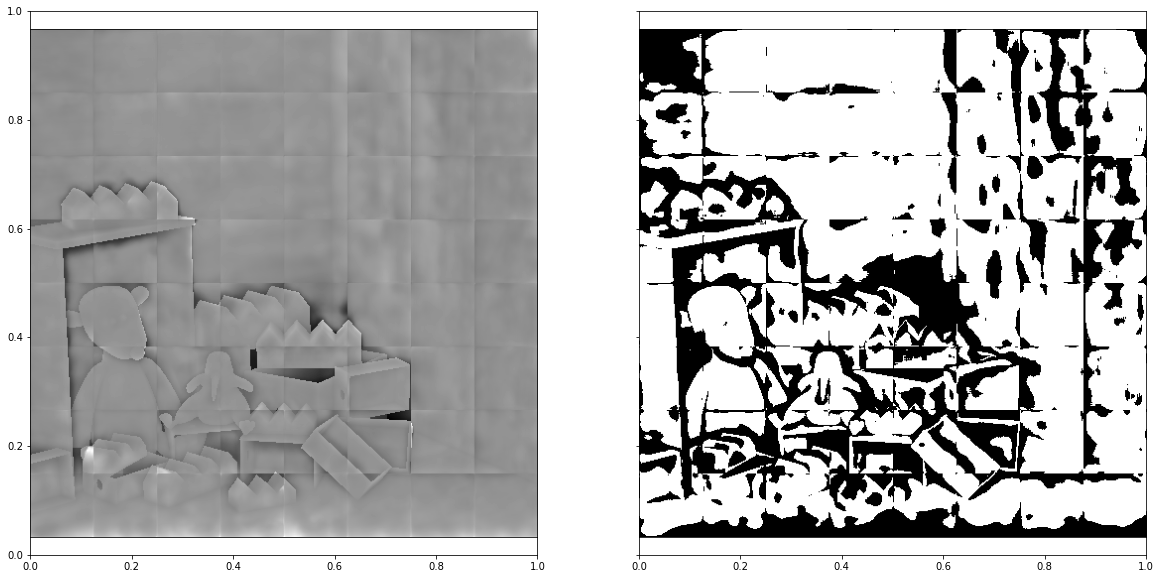

69.27146911621094
0.07384629071602469


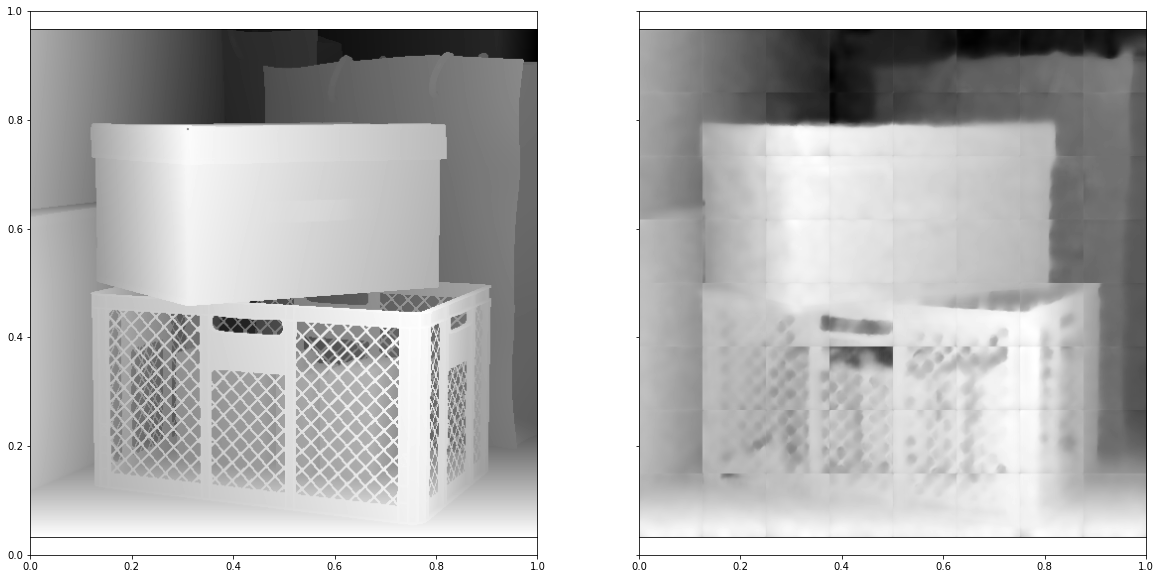

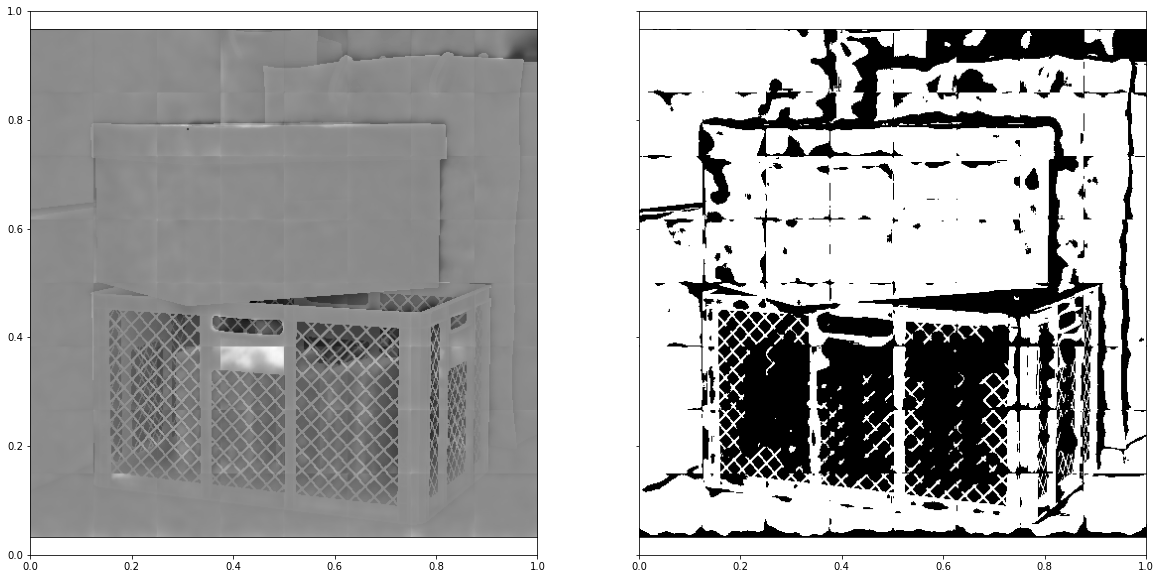

67.42134094238281
0.15143698783273113


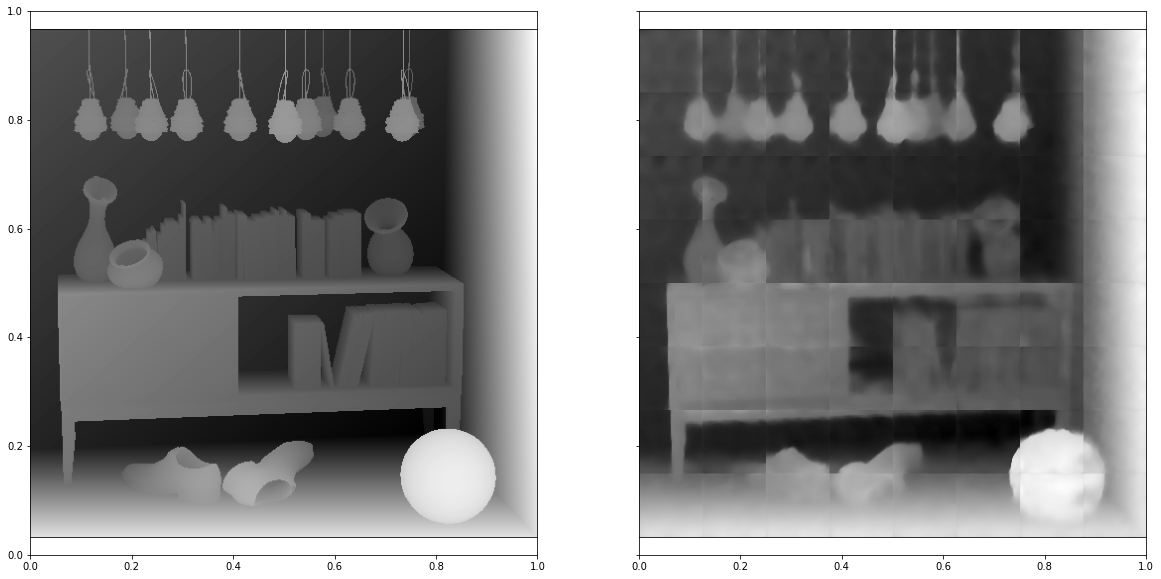

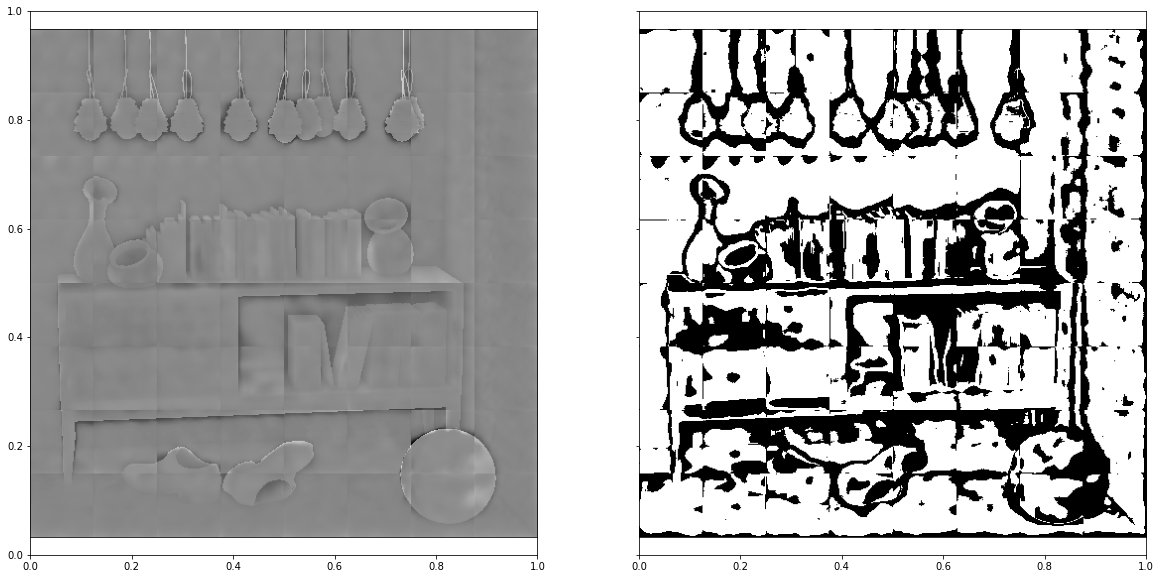

67.85049438476562
0.08426459878247204


In [13]:
X = [0, 64, 128, 192, 256, 320, 384, 448,
     0, 64, 128, 192, 256, 320, 384, 448,
     0, 64, 128, 192, 256, 320, 384, 448,
     0, 64, 128, 192, 256, 320, 384, 448,
     0, 64, 128, 192, 256, 320, 384, 448,
     0, 64, 128, 192, 256, 320, 384, 448,
     0, 64, 128, 192, 256, 320, 384, 448,
     0, 64, 128, 192, 256, 320, 384, 448]

Y = [0, 0, 0, 0, 0, 0, 0, 0,     
     64, 64, 64, 64, 64, 64, 64, 64,
     128, 128, 128, 128, 128, 128, 128, 128,
     192, 192, 192, 192, 192, 192, 192, 192,
     256, 256, 256, 256, 256, 256, 256, 256,
     320, 320, 320, 320, 320, 320, 320, 320, 
     384, 384, 384, 384, 384, 384, 384, 384,
     448, 448, 448, 448, 448, 448, 448, 448]

data = "hci_dataset/training/cotton"
Test(data, X, Y)

data = "hci_dataset/training/dino"
Test(data, X, Y)

data = "hci_dataset/training/boxes"
Test(data, X, Y)

data = "hci_dataset/training/sideboard"
Test(data, X, Y)

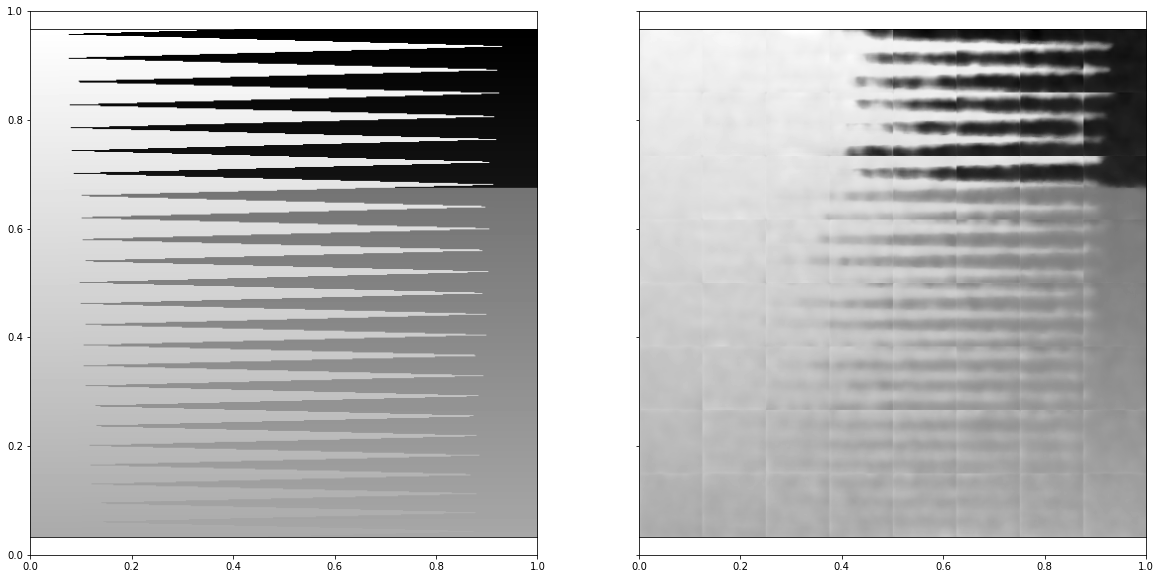

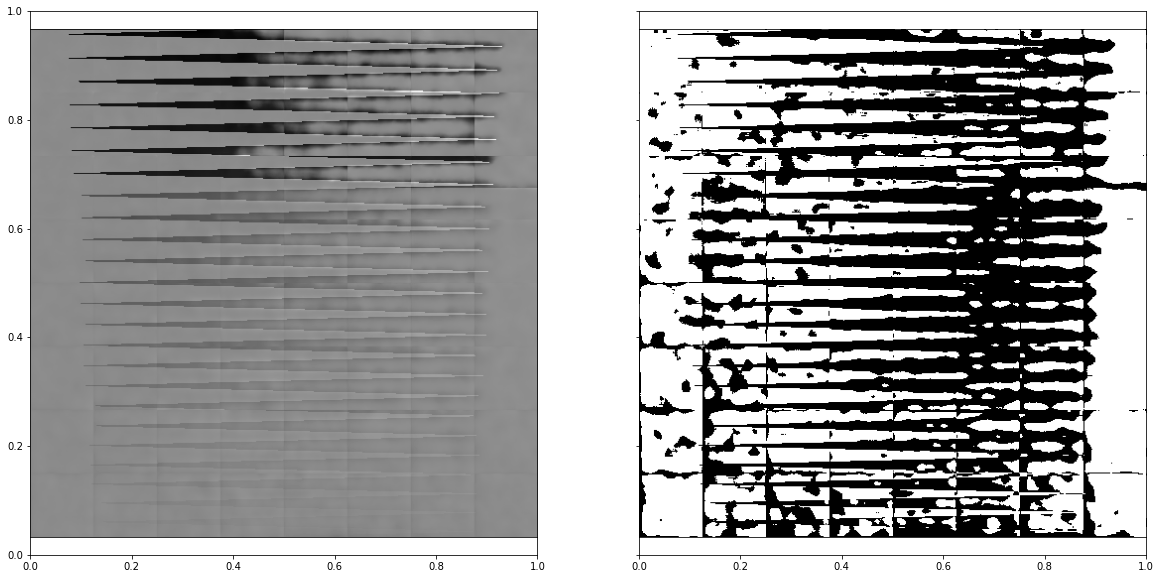

55.20210266113281
0.206037981821677


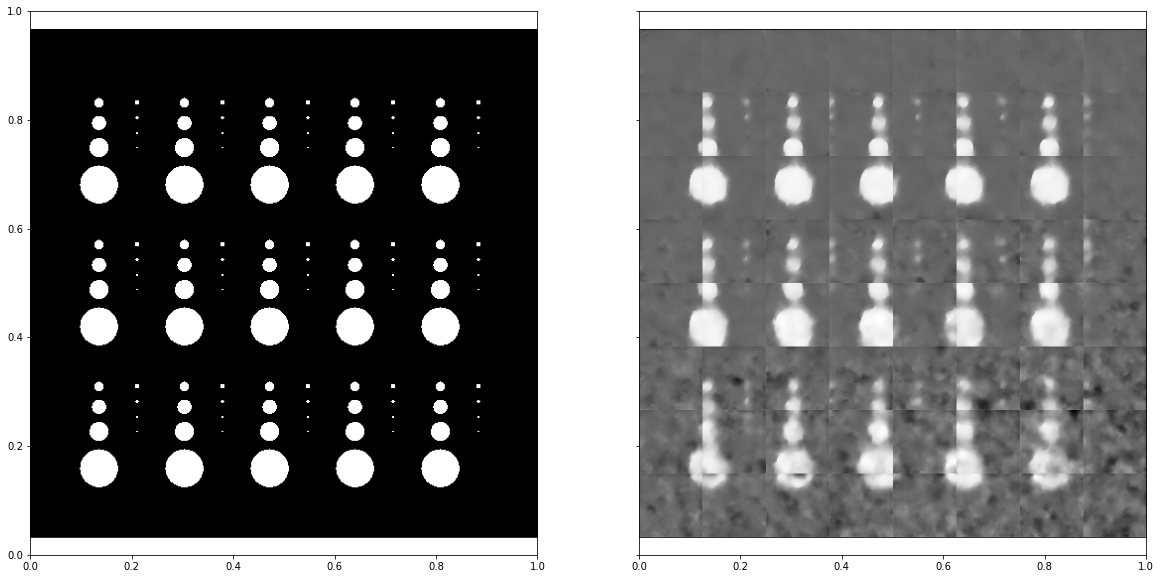

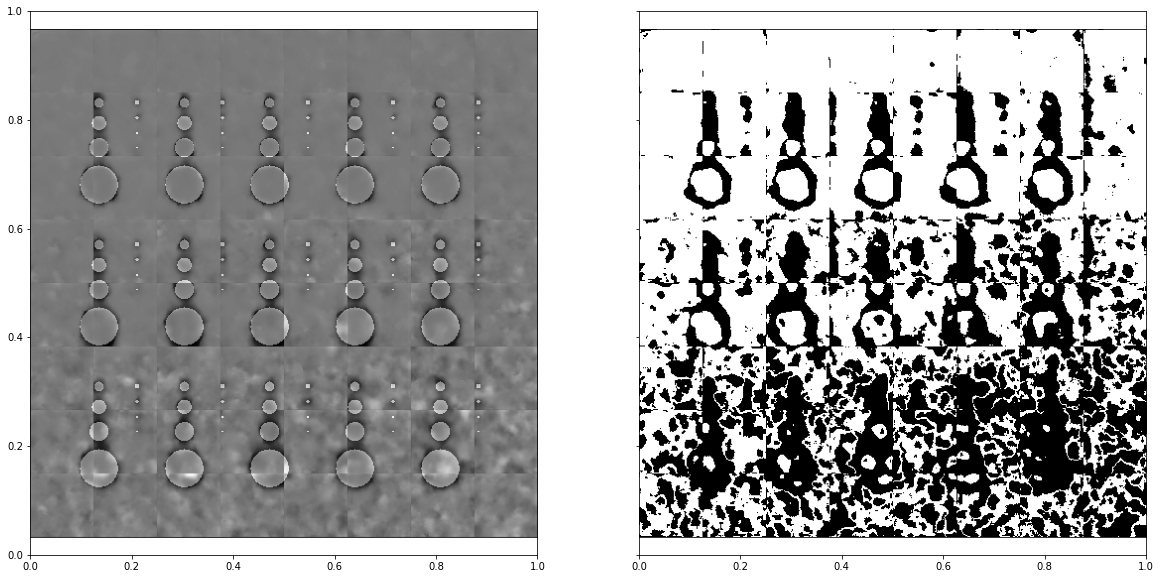

62.105560302734375
0.1083110123167188


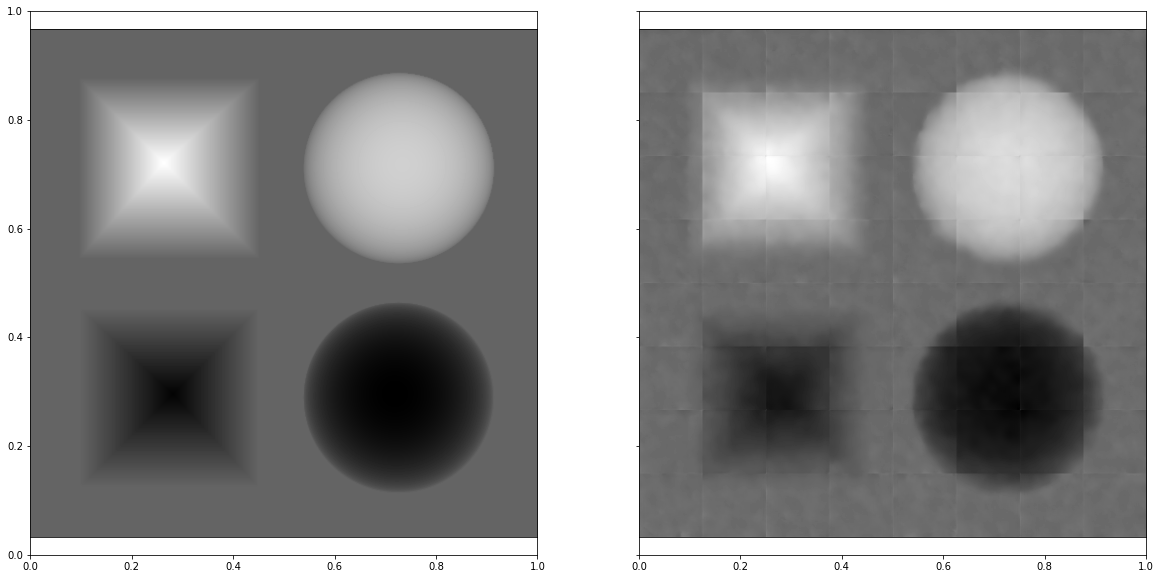

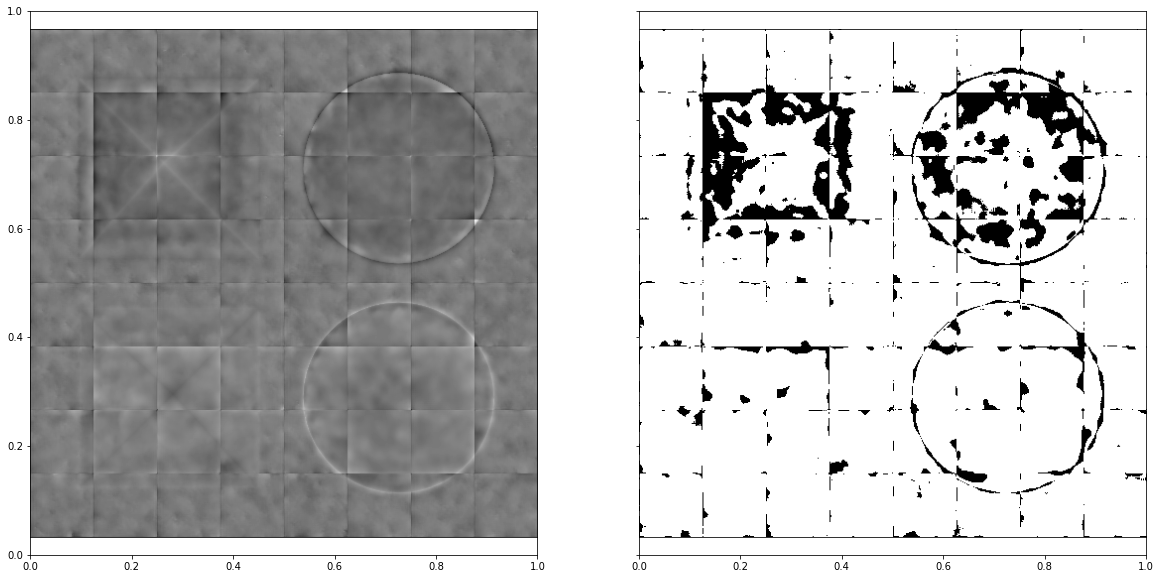

88.59062194824219
0.03207135934629137


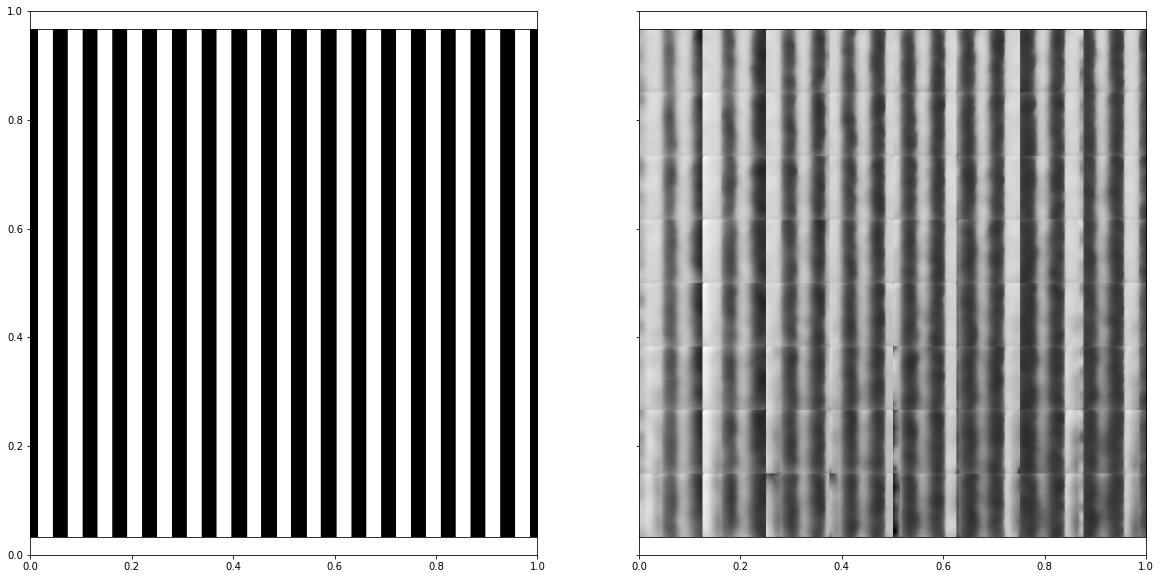

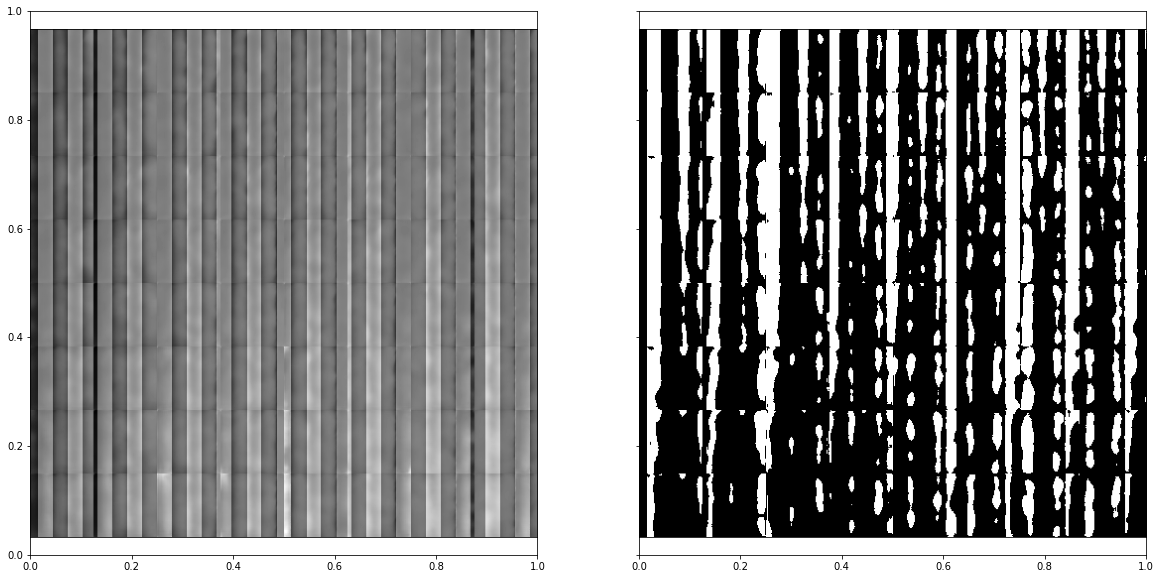

32.15370178222656
0.16756260237771414


In [14]:
data = "hci_dataset/stratified/backgammon"
Test(data, X, Y)

data = "hci_dataset/stratified/dots"
Test(data, X, Y)

data = "hci_dataset/stratified/pyramids"
Test(data, X, Y)

data = "hci_dataset/stratified/stripes"
Test(data, X, Y)